In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -q "/content/drive/MyDrive/Dissertation/Desertation_train_3model/дисертация_за_месяц/train.zip" -d "/content/data"


In [3]:
import yaml
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import random
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import StratifiedKFold
from torchvision import models, transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from PIL import Image
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, cohen_kappa_score, confusion_matrix,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize
import torchvision.transforms as transforms
from torch.cuda.amp import autocast, GradScaler

In [4]:
torch.backends.cudnn.benchmark = True

In [5]:
# Загрузка настроек
with open('/content/drive/MyDrive/Dissertation/Desertation_train_3model/дисертация_за_месяц/parametrs.yaml', 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

# Установка сидов
seed = config['experiment']['seed']
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)


# Загружаем модель и параметры
device = torch.device(config['training']['device'] if torch.cuda.is_available() else "cpu")
num_epochs = config['training']['num_epochs']
batch_size = config['training']['batch_size']
early_stopping_patience = config['training']['patience']
learning_rate = config['training'].get('learning_rate', 1e-4)
weight_decay = config['training'].get('weight_decay', 0.0)


root_dir = '/content/data/train'

In [6]:
# Путь к данным
train_csv = config['dataset']['train_csv']
df = pd.read_csv(train_csv)

In [7]:
df['true_label'] = df['true_label'].astype(int)
print("Распределение классов:")
print(df['true_label'].value_counts())

Распределение классов:
true_label
0    18867
1     6260
2     6260
Name: count, dtype: int64


In [8]:
from torchvision import transforms
from PIL import Image
import os



def get_transform_pipeline(config, label=None):
    transform_list = []

    transform_config = config.get('train_transforms', {})
    common_transforms = transform_config.get('common', [])
    transform_list.extend(parse_transforms(common_transforms, config))

    # Классы 1 и 2 получают сильные аугментации
    if label in [1, 2]:
        label_key = str(label)
        class_specific = transform_config.get(label_key, [])
        transform_list.extend(parse_transforms(class_specific, config))

    transform_list.extend([
        transforms.ToTensor(),
        transforms.Normalize(mean=config['dataset']['mean'], std=config['dataset']['std'])
    ])

    return transforms.Compose(transform_list)

def parse_transforms(transform_names, config):
    transform_ops = []
    image_size = config['dataset']['image_size']
    transform_ops.append(transforms.Resize(image_size))

    for name in transform_names:
        if name == "horizontal_flip":
            transform_ops.append(transforms.RandomHorizontalFlip())
        elif name == "vertical_flip":
            transform_ops.append(transforms.RandomVerticalFlip())
        elif name == "color_jitter":
            transform_ops.append(transforms.ColorJitter(0.3, 0.3, 0.2, 0.1))
        elif name == "random_affine":
            transform_ops.append(transforms.RandomAffine(15, translate=(0.05, 0.05), scale=(0.9, 1.1), shear=5))
        elif name == "gaussian_blur":
            transform_ops.append(transforms.GaussianBlur(kernel_size=3))
        elif name == "random_erasing":
            transform_ops.append(transforms.RandomErasing(p=0.2))
        else:
            raise ValueError(f"Неизвестная трансформация: {name}")

    return transform_ops



In [9]:
# Feature Extractor для ViT
class FundusDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, root_dir, config):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.config = config

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_name = row['image_name']
        label = int(row['true_label'])
        img_path = os.path.join(self.root_dir, str(label), img_name)
        image = Image.open(img_path).convert("RGB")

        transform = get_transform_pipeline(self.config, label=label)
        image = transform(image)

        # Возвращаем изображение, метку и имя файла
        return image, label, img_name


In [10]:
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [11]:
def train_model(model, train_loader, val_loader, optimizer, scheduler, device, config, fold=0):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    early_stopping_patience = config['training'].get('early_stopping_patience', 3)
    model_save_path = '/content/model/'
    num_epochs = config['training'].get('num_epochs', 20)

    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    patience_counter = 0

    scaler = GradScaler()  # грузим датасет

    if hasattr(model, 'vit'):
        for param in model.vit.parameters():
            param.requires_grad = False

    for epoch in range(num_epochs):
        if epoch == config['training'].get('freeze_encoder_epochs', 3):
            if hasattr(model, 'vit'):
                for param in model.vit.parameters():
                    param.requires_grad = True

        model.train()
        running_train_loss = 0.0

        for inputs, labels, _ in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast():  # train
                outputs = model(inputs)
                logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                loss = criterion(logits, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_train_loss += loss.item()

        scheduler.step()
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        all_labels, all_preds, all_probs, image_names = [], [], [], []

        hard_examples = []
        with torch.no_grad():
            for inputs, labels, filenames in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                with autocast():  # val
                    outputs = model(inputs)
                    logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                    loss = criterion(logits, labels)

                running_val_loss += loss.item()

                probs = torch.softmax(logits, dim=1)
                preds = torch.argmax(probs, dim=1)
                sample_losses = nn.functional.cross_entropy(logits, labels, reduction='none')

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
                image_names.extend(filenames)

                for i in range(len(labels)):
                    if preds[i] != labels[i] or sample_losses[i].item() > 1.0:  # порог по желанию
                        hard_examples.append({
                            'image_name': filenames[i],
                            'true_label': labels[i].item(),
                            'pred_label': preds[i].item(),
                            'loss': sample_losses[i].item()
                        })

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            save_path = os.path.join(model_save_path, f"baseline_vit_fold{fold + 1}.pth")
            os.makedirs(os.path.dirname(save_path), exist_ok=True)  # <--- эта строка создаёт директорию, если нужно
            torch.save(model.state_dict(), save_path)

        elif epoch > 0 and avg_val_loss > best_val_loss and avg_train_loss < train_losses[-2]:
            patience_counter += 1
            print(f"Validation loss ↑ while train loss ↓. Patience {patience_counter}/{early_stopping_patience}")
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered due to overfitting.")
                break

    # Final metrics
    num_classes = len(set(all_labels))
    print("\nFinal Metrics on Validation Set:")
    print(f"Accuracy: {accuracy_score(all_labels, all_preds):.4f}")
    print(f"Precision: {precision_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"Recall: {recall_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"F1 Score: {f1_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"Cohen's Kappa: {cohen_kappa_score(all_labels, all_preds):.4f}")
    print(f"Confusion Matrix:\n{confusion_matrix(all_labels, all_preds)}")

    # AUC-ROC
    try:
        y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))
        auc = roc_auc_score(y_true_bin, all_probs, multi_class='ovr', average='macro')
        print(f"AUC-ROC (OvR, macro): {auc:.4f}")
    except Exception as e:
        print(f"AUC-ROC calculation failed: {e}")

    plot_training_history(train_losses, val_losses)
    # Сохраняем hard examples
    if len(hard_examples) > 0:
        hard_df = pd.DataFrame(hard_examples)
        hard_df.to_csv(f"/content/model/hard_examples_fold{fold+1}.csv", index=False)
        with open(f"/content/model/hard_examples_fold{fold+1}.txt", "w") as f:
            for name in hard_df['image_name']:
                f.write(f"{name}\n")


    return all_labels, all_preds, all_probs, image_names

In [17]:
from sklearn.utils import resample
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, cohen_kappa_score, confusion_matrix, roc_auc_score
)
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader

def fine_tune_on_hard_examples(fold, config, root_dir, base_model_path, device, val_loader, train_df):

    hard_path = f"/content/model/hard_examples_fold{fold + 1}.txt"
    with open(hard_path, "r") as f:
        image_names = [line.strip() for line in f.readlines()]

    hard_df = pd.read_csv(f"/content/model/predictions_fold{fold + 1}.csv")
    hard_df = hard_df[hard_df['image_name'].isin(image_names)].reset_index(drop=True)

    print(f"Дообучение на {len(hard_df)} трудных примерах из фолда {fold + 1}")

    # Балансировка классов с приоритетом класса 0
    balanced_parts = [hard_df]
    already_used = set(hard_df['image_name'])
    class_counts = hard_df['true_label'].value_counts().to_dict()

    max_other = max(class_counts.get(1, 0), class_counts.get(2, 0))
    target_counts = {
        0: int(1.5 * max_other),  # Класс 0 — на 50% больше
        1: max_other,
        2: max_other
    }

    print("Целевое количество примеров в дообучении:")
    for cls, target in target_counts.items():
        print(f"  Класс {cls}: {target} (текущих: {class_counts.get(cls, 0)})")

    for cls in range(3):
        current_df = hard_df[hard_df['true_label'] == cls]
        count = len(current_df)
        need = target_counts[cls] - count
        if need > 0:
            candidates = train_df[(train_df['true_label'] == cls) & (~train_df['image_name'].isin(already_used))]
            if len(candidates) >= need:
                sampled = candidates.sample(n=need, random_state=fold)
            else:
                sampled = candidates
                print(f"  [!] Недостаточно примеров класса {cls} — нужно {need}, есть {len(candidates)}")

            already_used.update(sampled['image_name'])
            balanced_parts.append(sampled)
            print(f"  -> Добавлено {len(sampled)} примеров класса {cls} из train_df")
        else:
            print(f"  -> Класс {cls} не требует дополнения")

    balanced_df = pd.concat(balanced_parts).reset_index(drop=True)

    print("\nФинальное распределение классов в дообучении:")
    print(balanced_df['true_label'].value_counts())
    print(f"Итоговый размер датасета дообучения: {len(balanced_df)}")

    dataset = FundusDataset(balanced_df, root_dir=root_dir, config=config)
    loader = DataLoader(dataset, batch_size=config['training']['batch_size'], shuffle=True, num_workers=12, pin_memory=True)

    model = ViTForImageClassification.from_pretrained(
        "google/vit-base-patch16-224-in21k", num_labels=3, ignore_mismatched_sizes=True
    )
    model.load_state_dict(torch.load(base_model_path))
    model.to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    scaler = GradScaler()

    num_epochs = config['training'].get('fine_tune_epochs', 20)
    early_stop_patience = 3
    stop_counter = 0

    best_val_loss = float("inf")
    best_f1 = 0.0
    min_delta = 1e-4

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        for inputs, labels, _ in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs.logits, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(loader)

        # --- Валидация ---
        model.eval()
        all_labels, all_preds, all_probs = [], [], []
        total_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels, _ in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs.logits, labels)
                total_val_loss += loss.item()
                probs = torch.softmax(outputs.logits, dim=1)
                preds = torch.argmax(probs, dim=1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        avg_val_loss = total_val_loss / len(val_loader)
        f1 = f1_score(all_labels, all_preds, average='weighted')

        print(f"[Fine-tune] Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | F1: {f1:.4f}")

        improved = False
        if avg_val_loss < best_val_loss - min_delta:
            best_val_loss = avg_val_loss
            improved = True
        if f1 > best_f1 + min_delta:
            best_f1 = f1
            improved = True

        if improved:
            stop_counter = 0
            # Сохраняем лучшую модель по F1
            torch.save(model.state_dict(), f"/content/model/finetuned_model_fold{fold + 1}.pth")
        else:
            stop_counter += 1
            print(f" Нет улучшения (счётчик {stop_counter}/{early_stop_patience})")
            if stop_counter >= early_stop_patience:
                print(" Ранняя остановка.")
                break

    # --- Финальные метрики ---
    print("\n Final Metrics on Validation Set:")
    print(f"Accuracy: {accuracy_score(all_labels, all_preds):.4f}")
    print(f"Precision: {precision_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"Recall: {recall_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Cohen's Kappa: {cohen_kappa_score(all_labels, all_preds):.4f}")
    print(f"Confusion Matrix:\n{confusion_matrix(all_labels, all_preds)}")

    try:
        y_true_bin = label_binarize(all_labels, classes=[0, 1, 2])
        auc = roc_auc_score(y_true_bin, all_probs, multi_class='ovr', average='macro')
        print(f"AUC-ROC (OvR, macro): {auc:.4f}")
    except Exception as e:
        print(f"AUC-ROC calculation failed: {e}")



====== Fold 1 ======


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-11-0a04379195b2>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # грузим датасет
<ipython-input-11-0a04379195b2>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # train
<ipython-input-11-0a04379195b2>:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # val


Epoch 1/50 | Train Loss: 1.0988 | Val Loss: 1.0955
Epoch 2/50 | Train Loss: 1.0910 | Val Loss: 1.0879
Epoch 3/50 | Train Loss: 1.0834 | Val Loss: 1.0806
Epoch 4/50 | Train Loss: 0.9813 | Val Loss: 0.9114
Epoch 5/50 | Train Loss: 0.8594 | Val Loss: 0.8164
Epoch 6/50 | Train Loss: 0.7828 | Val Loss: 0.7551
Epoch 7/50 | Train Loss: 0.7288 | Val Loss: 0.7087
Epoch 8/50 | Train Loss: 0.6879 | Val Loss: 0.6759
Epoch 9/50 | Train Loss: 0.6576 | Val Loss: 0.6519
Epoch 10/50 | Train Loss: 0.6353 | Val Loss: 0.6349
Epoch 11/50 | Train Loss: 0.6182 | Val Loss: 0.6228
Epoch 12/50 | Train Loss: 0.6052 | Val Loss: 0.6130
Epoch 13/50 | Train Loss: 0.5947 | Val Loss: 0.6059
Epoch 14/50 | Train Loss: 0.5861 | Val Loss: 0.6001
Epoch 15/50 | Train Loss: 0.5794 | Val Loss: 0.5981
Epoch 16/50 | Train Loss: 0.5725 | Val Loss: 0.5916
Epoch 17/50 | Train Loss: 0.5674 | Val Loss: 0.5881
Epoch 18/50 | Train Loss: 0.5615 | Val Loss: 0.5855
Epoch 19/50 | Train Loss: 0.5567 | Val Loss: 0.5833
Epoch 20/50 | Train L

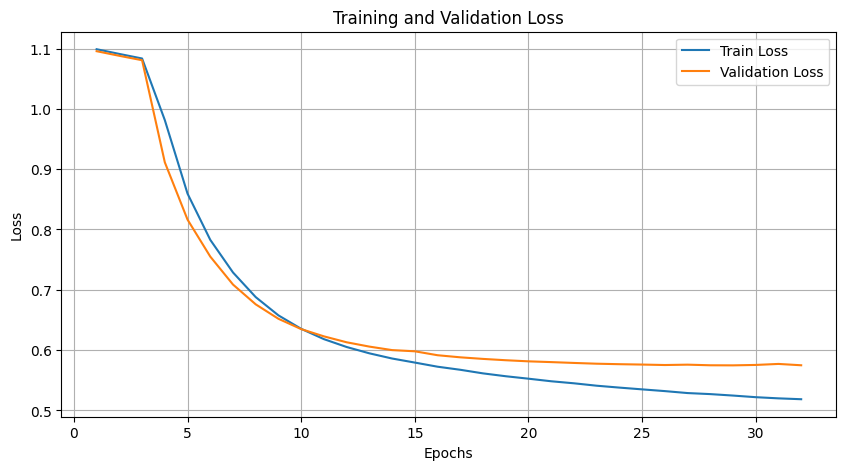


[Fine-tune] Дообучение модели на ошибках (Fold 1)
Дообучение на 1756 трудных примерах из фолда 1
  -> Добавлено 898 примеров класса 0 из train_df
  -> Добавлено 1234 примеров класса 2 из train_df
Итоговый размер датасета дообучения: 3888


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-12-532610b922ec>:55: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-12-532610b922ec>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get Dat

[Fine-tune] Epoch 1/50 | Train Loss: 0.7338 | Val Loss: 0.7325
[Fine-tune] Epoch 2/50 | Train Loss: 0.6808 | Val Loss: 0.7323
[Fine-tune] Epoch 3/50 | Train Loss: 0.6557 | Val Loss: 0.7539
 Ухудшение валидации: 14.98% (счётчик 1/2)
[Fine-tune] Epoch 4/50 | Train Loss: 0.6393 | Val Loss: 0.6716
[Fine-tune] Epoch 5/50 | Train Loss: 0.6135 | Val Loss: 0.7095
 Ухудшение валидации: 15.65% (счётчик 1/2)
[Fine-tune] Epoch 6/50 | Train Loss: 0.5841 | Val Loss: 0.6715
 Ухудшение валидации: 14.96% (счётчик 2/2)
 Ранняя остановка.

 Final Metrics on Validation Set:
Accuracy: 0.6809
Precision: 0.7692
Recall: 0.6809
F1 Score: 0.7024
Cohen's Kappa: 0.4944
Confusion Matrix:
[[3703 2586    0]
 [ 699 1354   34]
 [   9   11 2067]]
AUC-ROC (OvR, macro): 0.8687
 Fine-tuned model saved to: /content/model/finetuned_model_fold1.pth

====== Fold 2 ======


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-11-0a04379195b2>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # грузим датасет
<ipython-input-11-0a04379195b2>:3

Epoch 1/50 | Train Loss: 1.1224 | Val Loss: 1.1184
Epoch 2/50 | Train Loss: 1.1140 | Val Loss: 1.1101
Epoch 3/50 | Train Loss: 1.1059 | Val Loss: 1.1022
Epoch 4/50 | Train Loss: 0.9931 | Val Loss: 0.9205
Epoch 5/50 | Train Loss: 0.8618 | Val Loss: 0.8069
Epoch 6/50 | Train Loss: 0.7630 | Val Loss: 0.7281
Epoch 7/50 | Train Loss: 0.7001 | Val Loss: 0.6781
Epoch 8/50 | Train Loss: 0.6617 | Val Loss: 0.6494
Epoch 9/50 | Train Loss: 0.6372 | Val Loss: 0.6322
Epoch 10/50 | Train Loss: 0.6190 | Val Loss: 0.6167
Epoch 11/50 | Train Loss: 0.6056 | Val Loss: 0.6073
Epoch 12/50 | Train Loss: 0.5948 | Val Loss: 0.5998
Epoch 13/50 | Train Loss: 0.5856 | Val Loss: 0.5942
Epoch 14/50 | Train Loss: 0.5785 | Val Loss: 0.5900
Epoch 15/50 | Train Loss: 0.5719 | Val Loss: 0.5861
Epoch 16/50 | Train Loss: 0.5655 | Val Loss: 0.5835
Epoch 17/50 | Train Loss: 0.5602 | Val Loss: 0.5809
Epoch 18/50 | Train Loss: 0.5555 | Val Loss: 0.5792
Epoch 19/50 | Train Loss: 0.5510 | Val Loss: 0.5774
Epoch 20/50 | Train L

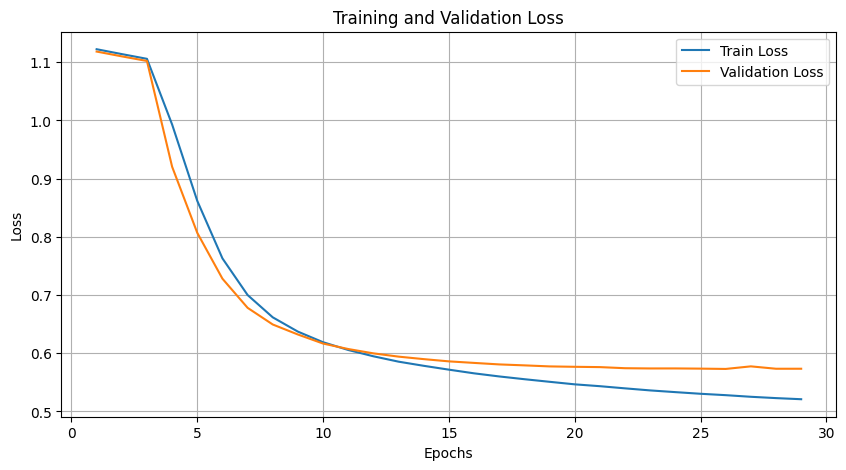


[Fine-tune] Дообучение модели на ошибках (Fold 2)
Дообучение на 1738 трудных примерах из фолда 2
  -> Добавлено 793 примеров класса 0 из train_df
  -> Добавлено 1165 примеров класса 2 из train_df
Итоговый размер датасета дообучения: 3696


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-12-532610b922ec>:55: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-12-532610b922ec>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get Dat

[Fine-tune] Epoch 1/50 | Train Loss: 0.7512 | Val Loss: 0.7050
[Fine-tune] Epoch 2/50 | Train Loss: 0.6938 | Val Loss: 0.7234
[Fine-tune] Epoch 3/50 | Train Loss: 0.6699 | Val Loss: 0.7385
 Ухудшение валидации: 10.23% (счётчик 1/2)
[Fine-tune] Epoch 4/50 | Train Loss: 0.6558 | Val Loss: 0.7017
[Fine-tune] Epoch 5/50 | Train Loss: 0.6445 | Val Loss: 0.7121
 Ухудшение валидации: 10.49% (счётчик 1/2)
[Fine-tune] Epoch 6/50 | Train Loss: 0.6362 | Val Loss: 0.7672
 Ухудшение валидации: 20.58% (счётчик 2/2)
 Ранняя остановка.

 Final Metrics on Validation Set:
Accuracy: 0.5685
Precision: 0.7090
Recall: 0.5685
F1 Score: 0.5911
Cohen's Kappa: 0.3580
Confusion Matrix:
[[2721 3545   23]
 [ 622 1148  317]
 [   3    4 2079]]
AUC-ROC (OvR, macro): 0.8104
 Fine-tuned model saved to: /content/model/finetuned_model_fold2.pth

====== Fold 3 ======


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-11-0a04379195b2>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # грузим датасет
<ipython-input-11-0a04379195b2>:3

Epoch 1/50 | Train Loss: 1.0896 | Val Loss: 1.0858
Epoch 2/50 | Train Loss: 1.0820 | Val Loss: 1.0784
Epoch 3/50 | Train Loss: 1.0747 | Val Loss: 1.0714
Epoch 4/50 | Train Loss: 0.9776 | Val Loss: 0.9136
Epoch 5/50 | Train Loss: 0.8590 | Val Loss: 0.8119
Epoch 6/50 | Train Loss: 0.7762 | Val Loss: 0.7437
Epoch 7/50 | Train Loss: 0.7174 | Val Loss: 0.6928
Epoch 8/50 | Train Loss: 0.6749 | Val Loss: 0.6586
Epoch 9/50 | Train Loss: 0.6465 | Val Loss: 0.6349
Epoch 10/50 | Train Loss: 0.6264 | Val Loss: 0.6200
Epoch 11/50 | Train Loss: 0.6125 | Val Loss: 0.6095
Epoch 12/50 | Train Loss: 0.6024 | Val Loss: 0.6006
Epoch 13/50 | Train Loss: 0.5944 | Val Loss: 0.5953
Epoch 14/50 | Train Loss: 0.5867 | Val Loss: 0.5926
Epoch 15/50 | Train Loss: 0.5812 | Val Loss: 0.5883
Epoch 16/50 | Train Loss: 0.5762 | Val Loss: 0.5844
Epoch 17/50 | Train Loss: 0.5717 | Val Loss: 0.5801
Epoch 18/50 | Train Loss: 0.5677 | Val Loss: 0.5778
Epoch 19/50 | Train Loss: 0.5634 | Val Loss: 0.5764
Epoch 20/50 | Train L

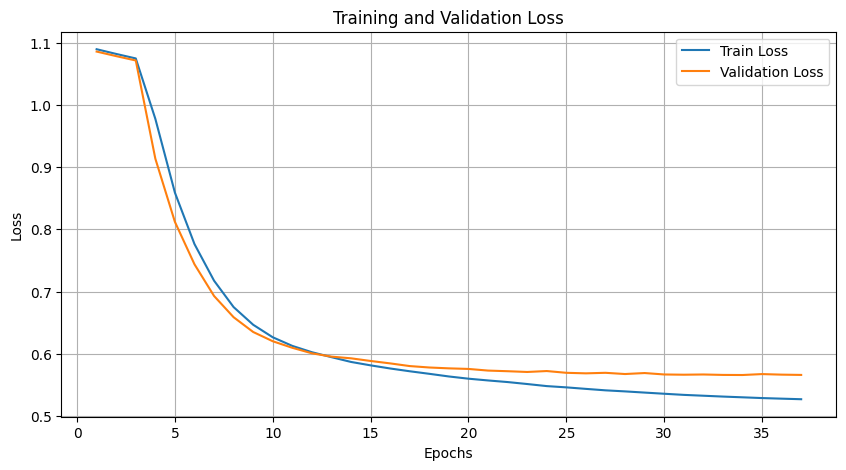


[Fine-tune] Дообучение модели на ошибках (Fold 3)
Дообучение на 1653 трудных примерах из фолда 3
  -> Добавлено 863 примеров класса 0 из train_df
  -> Добавлено 1159 примеров класса 2 из train_df
Итоговый размер датасета дообучения: 3675


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-12-532610b922ec>:55: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-12-532610b922ec>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get Dat

[Fine-tune] Epoch 1/50 | Train Loss: 0.7467 | Val Loss: 0.7290
[Fine-tune] Epoch 2/50 | Train Loss: 0.6821 | Val Loss: 0.7324
[Fine-tune] Epoch 3/50 | Train Loss: 0.6653 | Val Loss: 0.7570
 Ухудшение валидации: 13.80% (счётчик 1/2)
[Fine-tune] Epoch 4/50 | Train Loss: 0.6447 | Val Loss: 0.6941
[Fine-tune] Epoch 5/50 | Train Loss: 0.6251 | Val Loss: 0.7124
 Ухудшение валидации: 13.96% (счётчик 1/2)
[Fine-tune] Epoch 6/50 | Train Loss: 0.6014 | Val Loss: 0.6615
 Ухудшение валидации: 10.01% (счётчик 2/2)
 Ранняя остановка.

 Final Metrics on Validation Set:
Accuracy: 0.7307
Precision: 0.7534
Recall: 0.7307
F1 Score: 0.7394
Cohen's Kappa: 0.5393
Confusion Matrix:
[[4610 1678    1]
 [1011  956  119]
 [   6    2 2079]]
AUC-ROC (OvR, macro): 0.8591
 Fine-tuned model saved to: /content/model/finetuned_model_fold3.pth

Все фолды завершены. Результаты сохранены в 'kfold_vit_predictions.csv'


In [13]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import torch
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
import os

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
all_results = []
model_save_path = '/content/model/'
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['true_label'])):
    print(f"\n====== Fold {fold + 1} ======")

    train_df = df.iloc[train_idx].reset_index(drop=True)
    val_df = df.iloc[val_idx].reset_index(drop=True)

    # --- Создание датасетов и загрузчиков ---
    train_dataset = FundusDataset(train_df, root_dir=root_dir, config=config)
    val_dataset = FundusDataset(val_df, root_dir=root_dir, config=config)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=22, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=22, pin_memory=True)

    # --- Создание модели ---
    model = ViTForImageClassification.from_pretrained(
        "google/vit-base-patch16-224-in21k", num_labels=3, ignore_mismatched_sizes=True
    )
    model.to(device)

    # --- Оптимизатор и шедулер ---
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    scheduler_type = config['training'].get('scheduler', 'cosine').lower()
    if scheduler_type == 'cosine':
        scheduler = CosineAnnealingLR(optimizer, T_max=config['training']['num_epochs'])
    elif scheduler_type == 'step':
        scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
    else:
        raise ValueError(f"Unknown scheduler: {scheduler_type}")

    # --- Обновляем путь для сохранения модели ---
    model_path = os.path.join(model_save_path, f"baseline_vit_fold{fold + 1}.pth")
    config['training']['model_save_path'] = model_path

    #--- Обучение модели на фолде ---
    labels, preds, probs, image_names = train_model(
        model, train_loader, val_loader, optimizer, scheduler, device, config, fold=fold
    )
    # Сохранение результатов текущего фолда
    fold_df = pd.DataFrame({
        'image_name': image_names,
        'true_label': labels,
        'pred_label': preds,
        'fold': fold + 1
    })
    fold_df.to_csv(f"/content/model/predictions_fold{fold + 1}.csv", index=False)
    all_results.append(fold_df)

    # Дообучение модели на ошибках
    print(f"\n[Fine-tune] Дообучение модели на ошибках (Fold {fold + 1})")
    fine_tune_on_hard_examples(
        fold=fold,
        config=config,
        root_dir=root_dir,
        base_model_path=model_path,
        device=device,
        val_loader=val_loader,
        train_df=train_df  # ✅ добавлен аргумент
    )

# Итоговые результаты всех фолдов
final_df = pd.concat(all_results, ignore_index=True)
final_df.to_csv("/content/model/kfold_vit_predictions.csv", index=False)
print("\nВсе фолды завершены. Результаты сохранены в 'kfold_vit_predictions.csv'")



====== Fold 1 ======


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-11-0a04379195b2>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # грузим датасет
<ipython-input-11-0a04379195b2>:3

Epoch 1/50 | Train Loss: 1.0999 | Val Loss: 1.0961
Epoch 2/50 | Train Loss: 1.0920 | Val Loss: 1.0884
Epoch 3/50 | Train Loss: 1.0843 | Val Loss: 1.0810
Epoch 4/50 | Train Loss: 0.9675 | Val Loss: 0.9007
Epoch 5/50 | Train Loss: 0.8554 | Val Loss: 0.8169
Epoch 6/50 | Train Loss: 0.7847 | Val Loss: 0.7602
Epoch 7/50 | Train Loss: 0.7348 | Val Loss: 0.7191
Epoch 8/50 | Train Loss: 0.6973 | Val Loss: 0.6871
Epoch 9/50 | Train Loss: 0.6682 | Val Loss: 0.6634
Epoch 10/50 | Train Loss: 0.6462 | Val Loss: 0.6458
Epoch 11/50 | Train Loss: 0.6291 | Val Loss: 0.6321
Epoch 12/50 | Train Loss: 0.6154 | Val Loss: 0.6218
Epoch 13/50 | Train Loss: 0.6047 | Val Loss: 0.6150
Epoch 14/50 | Train Loss: 0.5956 | Val Loss: 0.6078
Epoch 15/50 | Train Loss: 0.5882 | Val Loss: 0.6021
Epoch 16/50 | Train Loss: 0.5810 | Val Loss: 0.5977
Epoch 17/50 | Train Loss: 0.5752 | Val Loss: 0.5943
Epoch 18/50 | Train Loss: 0.5702 | Val Loss: 0.5915
Epoch 19/50 | Train Loss: 0.5656 | Val Loss: 0.5896
Epoch 20/50 | Train L

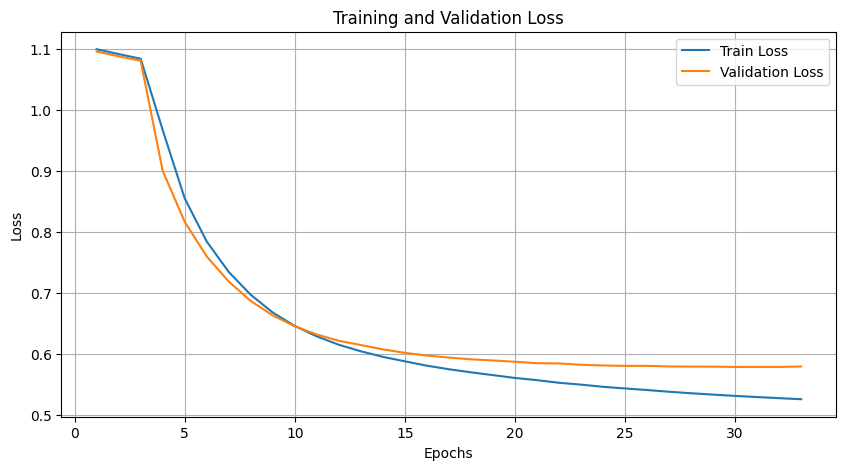


[Fine-tune] Дообучение модели на ошибках (Fold 1)
Дообучение на 1789 трудных примерах из фолда 1
Целевое количество примеров в дообучении:
  Класс 0: 2004 (текущих: 397)
  Класс 1: 1336 (текущих: 1336)
  Класс 2: 1336 (текущих: 56)
  -> Добавлено 1607 примеров класса 0 из train_df
  -> Класс 1 не требует дополнения
  -> Добавлено 1280 примеров класса 2 из train_df

Финальное распределение классов в дообучении:
true_label
0    2004
1    1336
2    1336
Name: count, dtype: int64
Итоговый размер датасета дообучения: 4676


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-17-f8e124f6792f>:73: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-17-f8e124f6792f>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get Dat

[Fine-tune] Epoch 1/50 | Train Loss: 0.7327 | Val Loss: 0.6342 | F1: 0.7756


<ipython-input-17-f8e124f6792f>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-17-f8e124f6792f>:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Fine-tune] Epoch 2/50 | Train Loss: 0.6957 | Val Loss: 0.6559 | F1: 0.7975


<ipython-input-17-f8e124f6792f>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-17-f8e124f6792f>:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Fine-tune] Epoch 3/50 | Train Loss: 0.6802 | Val Loss: 0.6240 | F1: 0.7724


<ipython-input-17-f8e124f6792f>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-17-f8e124f6792f>:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Fine-tune] Epoch 4/50 | Train Loss: 0.6570 | Val Loss: 0.6069 | F1: 0.7771


<ipython-input-17-f8e124f6792f>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-17-f8e124f6792f>:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Fine-tune] Epoch 5/50 | Train Loss: 0.6405 | Val Loss: 0.6244 | F1: 0.7986


<ipython-input-17-f8e124f6792f>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-17-f8e124f6792f>:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Fine-tune] Epoch 6/50 | Train Loss: 0.6219 | Val Loss: 0.5953 | F1: 0.8129


<ipython-input-17-f8e124f6792f>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-17-f8e124f6792f>:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Fine-tune] Epoch 7/50 | Train Loss: 0.5954 | Val Loss: 0.6499 | F1: 0.7522
 Нет улучшения (счётчик 1/3)


<ipython-input-17-f8e124f6792f>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-17-f8e124f6792f>:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Fine-tune] Epoch 8/50 | Train Loss: 0.5689 | Val Loss: 0.6053 | F1: 0.7963
 Нет улучшения (счётчик 2/3)


<ipython-input-17-f8e124f6792f>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-17-f8e124f6792f>:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Fine-tune] Epoch 9/50 | Train Loss: 0.5293 | Val Loss: 0.6089 | F1: 0.7979
 Нет улучшения (счётчик 3/3)
 Ранняя остановка.

 Final Metrics on Validation Set:
Accuracy: 0.7855
Precision: 0.8319
Recall: 0.7855
F1 Score: 0.7979
Cohen's Kappa: 0.6449
Confusion Matrix:
[[4610 1678    1]
 [ 508 1540   39]
 [   2   16 2069]]
AUC-ROC (OvR, macro): 0.9205

====== Fold 2 ======


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-11-0a04379195b2>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # грузим датасет
<ipython-input-11-0a04379195b2>:3

Epoch 1/50 | Train Loss: 1.0869 | Val Loss: 1.0838
Epoch 2/50 | Train Loss: 1.0794 | Val Loss: 1.0764
Epoch 3/50 | Train Loss: 1.0721 | Val Loss: 1.0693
Epoch 4/50 | Train Loss: 0.9695 | Val Loss: 0.8993
Epoch 5/50 | Train Loss: 0.8445 | Val Loss: 0.7967
Epoch 6/50 | Train Loss: 0.7577 | Val Loss: 0.7265
Epoch 7/50 | Train Loss: 0.7032 | Val Loss: 0.6849
Epoch 8/50 | Train Loss: 0.6696 | Val Loss: 0.6605
Epoch 9/50 | Train Loss: 0.6460 | Val Loss: 0.6396
Epoch 10/50 | Train Loss: 0.6281 | Val Loss: 0.6255
Epoch 11/50 | Train Loss: 0.6145 | Val Loss: 0.6156
Epoch 12/50 | Train Loss: 0.6035 | Val Loss: 0.6083
Epoch 13/50 | Train Loss: 0.5949 | Val Loss: 0.6026
Epoch 14/50 | Train Loss: 0.5864 | Val Loss: 0.5968
Epoch 15/50 | Train Loss: 0.5802 | Val Loss: 0.5925
Epoch 16/50 | Train Loss: 0.5738 | Val Loss: 0.5893
Epoch 17/50 | Train Loss: 0.5690 | Val Loss: 0.5871
Epoch 18/50 | Train Loss: 0.5644 | Val Loss: 0.5850
Epoch 19/50 | Train Loss: 0.5608 | Val Loss: 0.5823
Epoch 20/50 | Train L

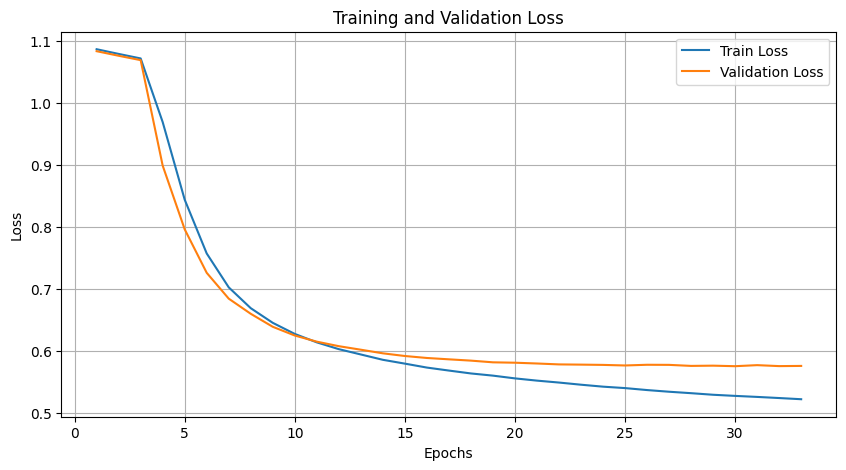


[Fine-tune] Дообучение модели на ошибках (Fold 2)
Дообучение на 1718 трудных примерах из фолда 2
Целевое количество примеров в дообучении:
  Класс 0: 1933 (текущих: 362)
  Класс 1: 1289 (текущих: 1289)
  Класс 2: 1289 (текущих: 67)
  -> Добавлено 1571 примеров класса 0 из train_df
  -> Класс 1 не требует дополнения
  -> Добавлено 1222 примеров класса 2 из train_df

Финальное распределение классов в дообучении:
true_label
0    1933
1    1289
2    1289
Name: count, dtype: int64
Итоговый размер датасета дообучения: 4511


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-17-f8e124f6792f>:73: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-17-f8e124f6792f>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get Dat

[Fine-tune] Epoch 1/50 | Train Loss: 0.7357 | Val Loss: 0.6274 | F1: 0.7650


<ipython-input-17-f8e124f6792f>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-17-f8e124f6792f>:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Fine-tune] Epoch 2/50 | Train Loss: 0.6851 | Val Loss: 0.6587 | F1: 0.8086


<ipython-input-17-f8e124f6792f>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-17-f8e124f6792f>:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Fine-tune] Epoch 3/50 | Train Loss: 0.6729 | Val Loss: 0.6323 | F1: 0.7968
 Нет улучшения (счётчик 1/3)


<ipython-input-17-f8e124f6792f>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-17-f8e124f6792f>:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Fine-tune] Epoch 4/50 | Train Loss: 0.6560 | Val Loss: 0.6108 | F1: 0.8039


<ipython-input-17-f8e124f6792f>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-17-f8e124f6792f>:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Fine-tune] Epoch 5/50 | Train Loss: 0.6406 | Val Loss: 0.6421 | F1: 0.8026
 Нет улучшения (счётчик 1/3)


<ipython-input-17-f8e124f6792f>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-17-f8e124f6792f>:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Fine-tune] Epoch 6/50 | Train Loss: 0.6182 | Val Loss: 0.5776 | F1: 0.8211


<ipython-input-17-f8e124f6792f>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-17-f8e124f6792f>:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Fine-tune] Epoch 7/50 | Train Loss: 0.6025 | Val Loss: 0.6503 | F1: 0.7741
 Нет улучшения (счётчик 1/3)


<ipython-input-17-f8e124f6792f>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-17-f8e124f6792f>:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Fine-tune] Epoch 8/50 | Train Loss: 0.5627 | Val Loss: 0.5819 | F1: 0.8230


<ipython-input-17-f8e124f6792f>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-17-f8e124f6792f>:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Fine-tune] Epoch 9/50 | Train Loss: 0.5257 | Val Loss: 0.5921 | F1: 0.8136
 Нет улучшения (счётчик 1/3)


<ipython-input-17-f8e124f6792f>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-17-f8e124f6792f>:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Fine-tune] Epoch 10/50 | Train Loss: 0.4747 | Val Loss: 0.5582 | F1: 0.8401


<ipython-input-17-f8e124f6792f>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-17-f8e124f6792f>:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Fine-tune] Epoch 11/50 | Train Loss: 0.4212 | Val Loss: 0.5957 | F1: 0.8195
 Нет улучшения (счётчик 1/3)


<ipython-input-17-f8e124f6792f>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-17-f8e124f6792f>:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Fine-tune] Epoch 12/50 | Train Loss: 0.3706 | Val Loss: 0.5944 | F1: 0.8306
 Нет улучшения (счётчик 2/3)


<ipython-input-17-f8e124f6792f>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-17-f8e124f6792f>:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Fine-tune] Epoch 13/50 | Train Loss: 0.3361 | Val Loss: 0.5089 | F1: 0.8825


<ipython-input-17-f8e124f6792f>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-17-f8e124f6792f>:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Fine-tune] Epoch 14/50 | Train Loss: 0.3246 | Val Loss: 0.5600 | F1: 0.8629
 Нет улучшения (счётчик 1/3)


<ipython-input-17-f8e124f6792f>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-17-f8e124f6792f>:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Fine-tune] Epoch 15/50 | Train Loss: 0.3142 | Val Loss: 0.6345 | F1: 0.8339
 Нет улучшения (счётчик 2/3)


<ipython-input-17-f8e124f6792f>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-17-f8e124f6792f>:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Fine-tune] Epoch 16/50 | Train Loss: 0.3079 | Val Loss: 0.6044 | F1: 0.8527
 Нет улучшения (счётчик 3/3)
 Ранняя остановка.

 Final Metrics on Validation Set:
Accuracy: 0.8449
Precision: 0.8775
Recall: 0.8449
F1 Score: 0.8527
Cohen's Kappa: 0.7402
Confusion Matrix:
[[5023 1265    1]
 [ 276 1739   72]
 [   1    8 2077]]
AUC-ROC (OvR, macro): 0.9550

====== Fold 3 ======


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-11-0a04379195b2>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # грузим датасет
<ipython-input-11-0a04379195b2>:3

Epoch 1/50 | Train Loss: 1.0785 | Val Loss: 1.0756
Epoch 2/50 | Train Loss: 1.0714 | Val Loss: 1.0687
Epoch 3/50 | Train Loss: 1.0646 | Val Loss: 1.0621
Epoch 4/50 | Train Loss: 0.9657 | Val Loss: 0.9005
Epoch 5/50 | Train Loss: 0.8574 | Val Loss: 0.8202
Epoch 6/50 | Train Loss: 0.7886 | Val Loss: 0.7611
Epoch 7/50 | Train Loss: 0.7389 | Val Loss: 0.7192
Epoch 8/50 | Train Loss: 0.7029 | Val Loss: 0.6882
Epoch 9/50 | Train Loss: 0.6749 | Val Loss: 0.6649
Epoch 10/50 | Train Loss: 0.6539 | Val Loss: 0.6466
Epoch 11/50 | Train Loss: 0.6367 | Val Loss: 0.6320
Epoch 12/50 | Train Loss: 0.6230 | Val Loss: 0.6210
Epoch 13/50 | Train Loss: 0.6116 | Val Loss: 0.6119
Epoch 14/50 | Train Loss: 0.6022 | Val Loss: 0.6056
Epoch 15/50 | Train Loss: 0.5941 | Val Loss: 0.6004
Epoch 16/50 | Train Loss: 0.5869 | Val Loss: 0.5949
Epoch 17/50 | Train Loss: 0.5807 | Val Loss: 0.5905
Epoch 18/50 | Train Loss: 0.5753 | Val Loss: 0.5865
Epoch 19/50 | Train Loss: 0.5704 | Val Loss: 0.5841
Epoch 20/50 | Train L

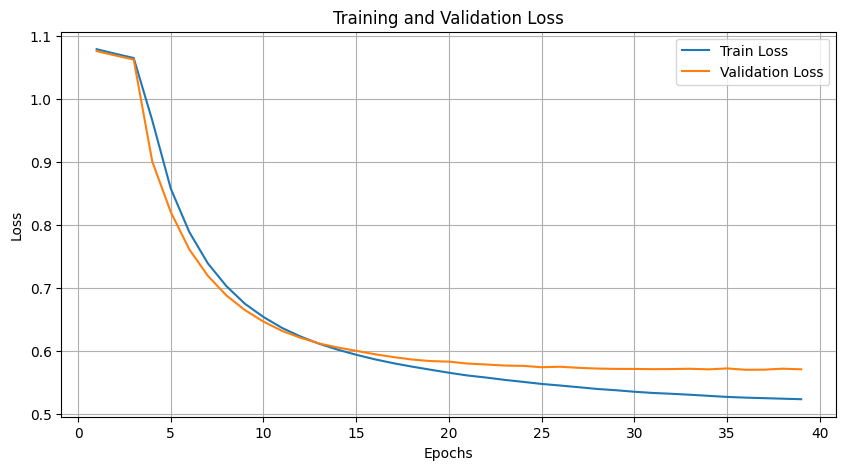


[Fine-tune] Дообучение модели на ошибках (Fold 3)
Дообучение на 1720 трудных примерах из фолда 3
Целевое количество примеров в дообучении:
  Класс 0: 1836 (текущих: 432)
  Класс 1: 1224 (текущих: 1224)
  Класс 2: 1224 (текущих: 64)
  -> Добавлено 1404 примеров класса 0 из train_df
  -> Класс 1 не требует дополнения
  -> Добавлено 1160 примеров класса 2 из train_df

Финальное распределение классов в дообучении:
true_label
0    1836
1    1224
2    1224
Name: count, dtype: int64
Итоговый размер датасета дообучения: 4284


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-17-f8e124f6792f>:73: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-17-f8e124f6792f>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get Dat

[Fine-tune] Epoch 1/50 | Train Loss: 0.7208 | Val Loss: 0.6510 | F1: 0.7426


<ipython-input-17-f8e124f6792f>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-17-f8e124f6792f>:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Fine-tune] Epoch 2/50 | Train Loss: 0.6835 | Val Loss: 0.6463 | F1: 0.7777


<ipython-input-17-f8e124f6792f>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-17-f8e124f6792f>:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Fine-tune] Epoch 3/50 | Train Loss: 0.6676 | Val Loss: 0.6347 | F1: 0.7730


<ipython-input-17-f8e124f6792f>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-17-f8e124f6792f>:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Fine-tune] Epoch 4/50 | Train Loss: 0.6515 | Val Loss: 0.6148 | F1: 0.7879


<ipython-input-17-f8e124f6792f>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-17-f8e124f6792f>:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Fine-tune] Epoch 5/50 | Train Loss: 0.6363 | Val Loss: 0.6121 | F1: 0.7721


<ipython-input-17-f8e124f6792f>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-17-f8e124f6792f>:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Fine-tune] Epoch 6/50 | Train Loss: 0.6252 | Val Loss: 0.6622 | F1: 0.7452
 Нет улучшения (счётчик 1/3)


<ipython-input-17-f8e124f6792f>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-17-f8e124f6792f>:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Fine-tune] Epoch 7/50 | Train Loss: 0.6050 | Val Loss: 0.6221 | F1: 0.7823
 Нет улучшения (счётчик 2/3)


<ipython-input-17-f8e124f6792f>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-17-f8e124f6792f>:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Fine-tune] Epoch 8/50 | Train Loss: 0.5837 | Val Loss: 0.6205 | F1: 0.7766
 Нет улучшения (счётчик 3/3)
 Ранняя остановка.

 Final Metrics on Validation Set:
Accuracy: 0.7724
Precision: 0.7825
Recall: 0.7724
F1 Score: 0.7766
Cohen's Kappa: 0.6030
Confusion Matrix:
[[4955 1331    3]
 [ 966 1042   78]
 [   0    3 2084]]
AUC-ROC (OvR, macro): 0.8899

Все фолды завершены. Результаты сохранены в 'kfold_vit_predictions.csv'


In [18]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import torch
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
import os

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
all_results = []
model_save_path = '/content/model/'
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['true_label'])):
    print(f"\n====== Fold {fold + 1} ======")

    train_df = df.iloc[train_idx].reset_index(drop=True)
    val_df = df.iloc[val_idx].reset_index(drop=True)

    # --- Создание датасетов и загрузчиков ---
    train_dataset = FundusDataset(train_df, root_dir=root_dir, config=config)
    val_dataset = FundusDataset(val_df, root_dir=root_dir, config=config)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=22, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=22, pin_memory=True)

    # --- Создание модели ---
    model = ViTForImageClassification.from_pretrained(
        "google/vit-base-patch16-224-in21k", num_labels=3, ignore_mismatched_sizes=True
    )
    model.to(device)

    # --- Оптимизатор и шедулер ---
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    scheduler_type = config['training'].get('scheduler', 'cosine').lower()
    if scheduler_type == 'cosine':
        scheduler = CosineAnnealingLR(optimizer, T_max=config['training']['num_epochs'])
    elif scheduler_type == 'step':
        scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
    else:
        raise ValueError(f"Unknown scheduler: {scheduler_type}")

    # --- Обновляем путь для сохранения модели ---
    model_path = os.path.join(model_save_path, f"baseline_vit_fold{fold + 1}.pth")
    config['training']['model_save_path'] = model_path

    #--- Обучение модели на фолде ---
    labels, preds, probs, image_names = train_model(
        model, train_loader, val_loader, optimizer, scheduler, device, config, fold=fold
    )
    # Сохранение результатов текущего фолда
    fold_df = pd.DataFrame({
        'image_name': image_names,
        'true_label': labels,
        'pred_label': preds,
        'fold': fold + 1
    })
    fold_df.to_csv(f"/content/model/predictions_fold{fold + 1}.csv", index=False)
    all_results.append(fold_df)

    # Дообучение модели на ошибках
    print(f"\n[Fine-tune] Дообучение модели на ошибках (Fold {fold + 1})")
    fine_tune_on_hard_examples(
        fold=fold,
        config=config,
        root_dir=root_dir,
        base_model_path=model_path,
        device=device,
        val_loader=val_loader,
        train_df=train_df  # ✅ добавлен аргумент
    )

# Итоговые результаты всех фолдов
final_df = pd.concat(all_results, ignore_index=True)
final_df.to_csv("/content/model/kfold_vit_predictions.csv", index=False)
print("\nВсе фолды завершены. Результаты сохранены в 'kfold_vit_predictions.csv'")
